### Working with copulas

We make a list of Us as follows:
 - For each location, we start with 16 observations corresponding to 16 sublocations. We treat these as seperate locations for the rest of this work.
 - The list of Us will be of length 2002 [day]. Each of these 2002 elements will be an array of length 4727 [Us] corresponding to the Us of each location for the day.

In [2]:
# packages
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from sklearn.gaussian_process.kernels import RBF
from math import sqrt
from joblib import Parallel, delayed
import psutil
import math
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
import scipy.sparse
sys.path.append('../')
from parallel.backends import BackendDummy as Backend
backend = Backend()


In [3]:
### load gamma
model_version = 7
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale" #(Keep this fixed)

# Run this to get the prediction data in a variable named city_data
# Getting data
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

test_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
#########

# create list of locations
loc_lat_lon = list(test_output.keys())
output_keys = ['pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p']

#'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
loc_lat_lon.remove('lat_50.95_49.35_lon_-4.55_-2.95')
#  'pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p'

# formatting data
gamma_outputs = [[[],[],[],[],[],[]] for places in range(len(loc_lat_lon))] 
for location_idx in range(len(loc_lat_lon)):
    gamma_outputs[location_idx].append([float(loc_lat_lon[location_idx].split('_')[i]) for i in [1,2,4,5]])
    gamma_outputs[location_idx].append(test_output[loc_lat_lon[location_idx]]['mask'][0][0])
    for output_idx in range(6):
        for week in range(286):
            for day in range(7):
                #check for date, as date is formatted differently from the rest.
                if output_idx==4:
                    if day==0:
                        gamma_outputs[location_idx][output_idx].append(np.array(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week],dtype='datetime64[D]'))
                    else:
                        gamma_outputs[location_idx][output_idx].append('')                   
                else:
                    gamma_outputs[location_idx][output_idx].append(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week][day])
# Loading data for Us
with open('g_us.txt','rb') as f:
    g_us = pickle.load(f)

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/checkpoints/epoch=12-step=25572-val_loss_loss=-0.391-val_metric_mse_rain=21.531.ckpt']


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# create list of idexes corresponding to land locations
is_loc_land = [] # boolean vector indicating for each location if it is land
                 #[0,1,...,0] length=#locations
                 # if it is not land, that location is getting skipped in gamma_outputs
                 # WILL NEED TO TAKE THIS INTO ACCOUNT ONCE I PLOT THE MAP
for loc in loc_lat_lon:
    for week in range(1):
        for day in range(1):
            for row in range(4):
                for column in range(4):
                    if test_output[loc]['mask'][week][day][row][column]==1:
                        is_loc_land.append(1)
                    else:
                        is_loc_land.append(0)

idx_land = []                       
for idx,b in enumerate(is_loc_land):
    if b==1:
        idx_land.append(idx)

In [5]:
#correct any code-approximation related errors
for day in range(len(g_us)):
    for location in range(len(g_us[0])):
        if g_us[day][location]==0:
            g_us[day][location]=0.0001
        if g_us[day][location]==1:
            g_us[day][location]=0.999
        g_us[day][location]=abs(g_us[day][location])

In [6]:
# Copula classes

# Gaussian
# This class is with sigma fixed at 1 - This is what is used for the rest of this notebook
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=False):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L)
        #sigma should be in theta ##############################

        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L) 
        #sigma should be in theta ##############################

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll

# Clayton
class Clayton():
    def __init__(self,n=2):
        '''
        Class to fit and work with a Clayton copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.n=n # dimension

    def sim(draws=10,theta=1):
        '''
        Simulates m draws from the Clayton copula density
        '''
        # not sure how yet.

    def eval_nll(self,theta=10,data=[[0.4,0.6],[0.001,0.01],[0.1,0.1],[0.8,0.9],[0.1,0.0001],[0.3,0.1]]):
        '''
        theta: the parameter of the Clayton copula in [0,inf).
        
        data: [[u1_(k=1) ,..., un_(k=1)] ,..., [u1_(k=k) ,..., un(k=k)]] one set of (n of them: one for each location) us for each day 1 to T.
        '''
        # Compute the pdf by looping over each day, and adding the nll for that day to the result. 

        #### second atempt
        nll=0
        n=self.n

        for day_data in data:
            nll += n*(1+theta) + (n+(1/theta)) * np.log(1-n + np.sum(np.power(day_data,-theta)))
            nll += -np.sum([np.log(u) + np.log(j*theta +1) for j,u in enumerate(day_data)])
        
        return nll

# Bardossy2011+rain_occurence copula

# def parallelised nll: global function called during parrallel jobs. 

def parallel_nll(chunck, Us_didrain_Usbin, norm_us, cov_mat, cov_mat2):
    nll = 0
    didrain = Us_didrain_Usbin[1]
    Us_b = Us_didrain_Usbin[2]
    for day in chunck:# contribution of the Zs - normal copula for occurence of rain
        nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=1) for obs in Us_b[day]],mean=np.zeros(len(Us_b[0])),cov=cov_mat2) 
        nll+=-np.sum([scs.norm.logpdf(scs.norm.ppf(obs,loc=0,scale=1),loc=0,scale=1) for obs in Us_b[day]])
        
        for pair in itertools.combinations(range(13),2):#main contribution - bardossy copula for rain
            if didrain[day][pair[0]]+didrain[day][pair[1]]==0: #I1
                nll += scs.multivariate_normal.logpdf([norm_us[day][pair[0]],norm_us[day][pair[1]]],mean=np.zeros(2),cov=np.matrix([[1, cov_mat[pair[0]][pair[1]]], [cov_mat[pair[0]][pair[1]], 1]]))
            if didrain[day][pair[0]]+didrain[day][pair[1]]==1: #I2 - have [1or0]*ll + [0or1]*ll to add the correct amount, depending on where it rained.
                nll += (didrain[day][pair[1]])*scs.norm.logpdf((norm_us[day][pair[0]]-norm_us[day][pair[1]]*cov_mat[pair[0]][pair[1]])/(sqrt(1-np.power(cov_mat[pair[0]][pair[1]],2)))) + (1-didrain[day][pair[1]])*scs.norm.logpdf((norm_us[day][pair[1]]-norm_us[day][pair[0]]*cov_mat[pair[0]][pair[1]])/(sqrt(1-np.power(cov_mat[pair[0]][pair[1]],2)))) 
                nll += (didrain[day][pair[1]])*scs.norm.logpdf(norm_us[day][pair[1]]) + (1-didrain[day][pair[1]])*scs.norm.logpdf(norm_us[day][pair[0]])
            if didrain[day][pair[0]]+didrain[day][pair[1]]==0: #I3
                nll += scs.multivariate_normal.logcdf([norm_us[day][pair[0]],norm_us[day][pair[1]]],mean=np.zeros(2),cov=np.matrix([[1, cov_mat[pair[0]][pair[1]]], [cov_mat[pair[0]][pair[1]], 1]]))
    return nll

class cop_bardossy():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.L=L
    
    def nll(self,theta,Us_didrain_Usbin): #not parrallelised
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        Us: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        didrain: 0/1 values in the same structure as Us, indicators of rain (1=rain).
        '''
        nll = 0
        Us = Us_didrain_Usbin[0]
        didrain = Us_didrain_Usbin[1]
        Us_b = Us_didrain_Usbin[2]
        theta1,theta2 = theta[0],theta[1]
        # transform Us into invNorms
        norm_us = [[] for i in range(len(Us)) ]
        for day in range(len(Us)):
            norm_us[day]=[scs.norm.ppf(u) for u in Us[day]]
            
        # kernels
        cov_mat=np.nan_to_num(RBF(length_scale=theta1).__call__(self.L),copy=False,nan=0)
        cov_mat2=np.nan_to_num(RBF(length_scale=theta2).__call__(self.L),copy=False,nan=0)

        #loglikelihood

        for day in range(len(Us)):# contribution of the Zs - normal copula for occurence of rain
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=1) for obs in Us_b[day]],mean=np.zeros(len(Us_b[0])),cov=cov_mat2) 
            nll+=-np.sum([scs.norm.logpdf(scs.norm.ppf(obs,loc=0,scale=1),loc=0,scale=1) for obs in Us_b[day]])
            for pair in itertools.combinations(range(13),2):#main contribution - bardossy copula for rain
                if didrain[day][pair[0]]+didrain[day][pair[1]]==0: #I1
                    nll += scs.multivariate_normal.logpdf([norm_us[day][pair[0]],norm_us[day][pair[1]]],mean=np.zeros(2),cov=np.matrix([[1, cov_mat[pair[0]][pair[1]]], [cov_mat[pair[0]][pair[1]], 1]]))
                if didrain[day][pair[0]]+didrain[day][pair[1]]==1: #I2 - have [1or0]*ll + [0or1]*ll to add the correct amount, depending on where it rained.
                    nll += (didrain[day][pair[1]])*scs.norm.logpdf((norm_us[day][pair[0]]-norm_us[day][pair[1]]*cov_mat[pair[0]][pair[1]])/(sqrt(1-np.power(cov_mat[pair[0]][pair[1]],2)))) + (1-didrain[day][pair[1]])*scs.norm.logpdf((norm_us[day][pair[1]]-norm_us[day][pair[0]]*cov_mat[pair[0]][pair[1]])/(sqrt(1-np.power(cov_mat[pair[0]][pair[1]],2)))) 
                    nll += (didrain[day][pair[1]])*scs.norm.logpdf(norm_us[day][pair[1]]) + (1-didrain[day][pair[1]])*scs.norm.logpdf(norm_us[day][pair[0]])
                if didrain[day][pair[0]]+didrain[day][pair[1]]==0: #I3
                    nll += scs.multivariate_normal.logcdf([norm_us[day][pair[0]],norm_us[day][pair[1]]],mean=np.zeros(2),cov=np.matrix([[1, cov_mat[pair[0]][pair[1]]], [cov_mat[pair[0]][pair[1]], 1]]))
        return -nll

    def p_nll(self,theta,Us_didrain_Usbin): # parallelised
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        Us: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        didrain: 0/1 values in the same structure as Us, indicators of rain (1=rain).
        '''
        theta1,theta2 = theta[0],theta[1]
        Us = Us_didrain_Usbin[0]
        # transform Us into invNorms
        norm_us = [[] for i in range(len(Us)) ]
        for day in range(len(Us)):
            norm_us[day]=[scs.norm.ppf(u) for u in Us[day]]
            
        # kernels
        cov_mat=np.nan_to_num(RBF(length_scale=theta1).__call__(self.L),copy=False,nan=0)
        cov_mat2=np.nan_to_num(RBF(length_scale=theta2).__call__(self.L),copy=False,nan=0)

        #loglikelihood
        size = math.ceil(len(Us)/psutil.cpu_count())
        days_chuncks = [[i for i in range(len(Us))][x:x+size] for x in range(0,len(Us), size)]
        list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(parallel_nll)(chunck, Us_didrain_Usbin, norm_us, cov_mat, cov_mat2) for chunck in days_chuncks)
        
        return -np.sum(list_nll)

In [7]:
# distance matrix for kernel

#first create correct set of coordinates for eavch of the 4272 locations:

loc_coordinates_4272 = [] # matrix of length 4272 [ [lat1,lon1] , [lat2,lon2] , ... , [lat4272,lon4272] ]
for loc in range(344):
    for row in range(4):
        for col in range(4):
            if gamma_outputs[loc][7][row][col]==1: #check if land location
                x = [gamma_outputs[loc][6][0],gamma_outputs[loc][6][2]] # coordinates of topleft of big square, eg. [57.75, -5.75]
                # rectify the 16by16 square into a 4by4
                x[0] = x[0]-0.6
                x[1] = x[1]+0.6
                # finally, select the correct entry out of the 16 in the 4by4. [lat,lon]
                loc_coordinates_4272.append([round(x[0]+row*0.1,2) ,round(x[1]+col*0.1,2)])

#Now, can compute distance matrix:
dist_mat = distance_matrix(loc_coordinates_4272,loc_coordinates_4272)

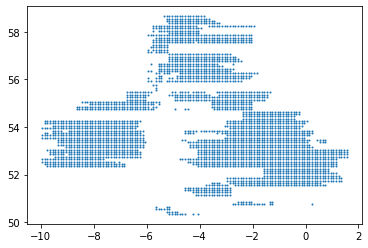

In [7]:
plt.scatter([loc_coordinates_4272[i][1] for i in range(3098)],[loc_coordinates_4272[i][0] for i in range(3098)],s=1)

### Normal copula

In [9]:
norm_cop_loconly(L=dist_mat[48:80,48:80]).nll(theta=[3,3],data=[g_us[i][48:80] for i in range(2002)])

20498762.83935404

### Clayton

In [ ]:
Clayton(n=16).eval_nll(theta=3,data=[g_us[i][48:80] for i in range(2002)]) # takes 22s

77788.18569187525

In [ ]:
# fval: 14326075.26123136 theta: 0.00806025 time: 1h
#dual_annealing(Clayton(n=4272).eval_nll,bounds=[[0.00000001,10]],args=[g_us],maxiter=1000)
# first 16: 0.45316421

### Bardossy 2011 copula

In [7]:
# load censored us and z_i #1m

# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.
#[place][parameter][day][row][column]
#0:i,1:location,2:pred_mu,3:pred_disp,4:pred_p,5:target_rain_value,6:dates
 #no need to run this part as it's saved with pickle
'''censored_us = [[] for i in range(2002)]
g_zs = [[] for i in range(2002)]

for day in tqdm(range(2002)):
    for location in range(267):
        for row in range(4):
            for column in range(4):
                censored_us[day].append(gamma_outputs[location][2][day][row][column])   
                g_zs[day].append(np.power(1-gamma_outputs[location][5][day][row][column],1-gamma_outputs[location][2][day][row][column]))   
for day in tqdm(range(2002)):
    for location in range(len(g_zs[day])):
        if g_zs[day][location]>0.999:
            g_zs[day][location] = 0.9999
        g_zs[day][location] = abs(g_zs[day][location]) '''

'''with open('censored_us.txt','wb') as f:
    pickle.dump(censored_us,f)
with open('g_zs.txt','wb') as f:
    pickle.dump(g_zs,f)'''
#just load
with open('censored_us.txt','rb') as f:
    did_rain_01 = pickle.load(f)
with open('g_zs.txt','rb') as f:
    g_zs = pickle.load(f)

In [14]:
cop_bardossy(L=dist_mat[48:80,48:80]).nll([0.45,0.24],[[g_us[i][48:80]for i in range(300)],[censored_us[i][48:80]for i in range(300)],[g_zs[i][48:80]for i in range(300)]]) #22s

KeyboardInterrupt: 

In [15]:
cop_bardossy(L=dist_mat[48:80,48:80]).p_nll([0.1,0.1],[[g_us[i][48:80]for i in range(2002)],[censored_us[i][48:80]for i in range(2002)],[g_zs[i][48:80]for i in range(2002)]]) #22s

306381.7809577087

In [19]:
dual_annealing(cop_bardossy(L=dist_mat[48:80,48:80]).p_nll,bounds=[[0.5,10],[0.25,10]],args=[[[g_us[i][48:80]for i in range(2002)],[censored_us[i][48:80]for i in range(2002)],[g_zs[i][48:80]for i in range(2002)]]],maxfun=400)# 22/1maxfun
#0.24580719, 0.49390414 , feval:1123 , 16 locs

     fun: 112204.5414053855
 message: ['Maximum number of function call reached during annealing']
    nfev: 400
    nhev: 0
     nit: 92
    njev: 10
  status: 0
 success: False
       x: array([0.67495809, 0.35775013])

### Truncated Gaussian Copula

The following are used below. They have the appropriate format for the MLE function, ie: 2002 rows of 4272 entries each, corresponding to 2002 days for 4272 location.

g_us : Us from the GNM\
did_rain_01 : indicator for observed rain \
inv_us : normal ppf of Us

In [8]:
# Load g_us, did_rain, inv_us + remove water locations 
#list[location][parameter][day]
#  0'pred_mu', 1'pred_disp', 2'target_did_rain',3 'target_rain_value',4 'date', 5'pred_p'
'''g2_us = [[] for i in range(2002)]
for day in tqdm(range(2002)):
    for loc in range(len(gamma_outputs)):
        for row in range(4):
            for column in range(4):
                #rv = scs.gamma(scale=m*d,a=1/d) 
                if gamma_outputs[loc][2][day][row][column]==0: # dry -> 1-p
                    g2_us[day].append(1-gamma_outputs[loc][5][day][row][column])
                else: # wet -> 1-p + p*gamma
                    g2_us[day].append((1-gamma_outputs[loc][5][day][row][column]) + ((gamma_outputs[loc][5][day][row][column])*scs.gamma(scale=gamma_outputs[loc][0][day][row][column]*gamma_outputs[loc][1][day][row][column],a=1/gamma_outputs[loc][1][day][row][column]).cdf(gamma_outputs[loc][3][day][row][column])))
                
with open('g2_us.txt','wb') as f:
    pickle.dump(g2_us,f)

inv_us = [[] for i in range(2002)]
for day in tqdm(range(2002)):
    for loc in range(len(g2_us[0])):
        inv_us[day].append(scs.norm.ppf(g2_us[day][loc]))
with open('inv_Us.txt','wb') as f:
    pickle.dump(inv_us,f)

did_rain_01 = [[] for i in range(2002)]
for day in tqdm(range(2002)):
    for loc in range(len(gamma_outputs)):
        for row in range(4):
            for column in range(4):
                did_rain_01[day].append(gamma_outputs[loc][2][day][row][column])
with open('did_rain_01.txt','wb') as f:
    pickle.dump(did_rain_01,f)'''
with open('inv_Us.txt','rb') as f:
    inv_us = pickle.load(f)
with open('did_rain_01.txt','rb') as f:
    did_rain_01 = pickle.load(f)
with open('g2_us.txt','rb') as f:
    g2_us = pickle.load(f)

g2_us = [[g2_us[i][k] for k in idx_land] for i in range(len(g2_us))]
inv_us = [[inv_us[i][k] for k in idx_land] for i in range(len(inv_us))]
did_rain_01 = [[did_rain_01[i][k] for k in idx_land] for i in range(len(did_rain_01))]

### Need to remove data for water locations using idx_land

In [9]:
# MC estimate - Correct and working
def mc_cdf(rvs,cov_matrix,ppf_us):
    '''
    rvs: [[set1], ... , [set m]] each set of length = #locations = n.
    cov_matrix: covariance matrix between the locations in question.
    ppf_us: [u1, ... , un] length = # locs.
    '''    
    # rvs are mean 0 already, but need different covariance
    cholesk_mat = np.linalg.cholesky(cov_matrix)
    normcov_vars = [np.asarray(cholesk_mat@rvs[i])[0] for i in range(len(rvs))]
    out = max(0.0001,np.sum([np.sum([normcov_vars[m][n]<ppf_us[n] for n in range(len(ppf_us))])==len(ppf_us) for m in range(len(normcov_vars))]))
    return out/len(rvs)       
    
    
#rand_vars = scs.multivariate_normal.rvs(np.zeros(len(submat11.todense())),np.eye(len(submat11.todense())),size=100000)

In [19]:
rand_vars = scs.multivariate_normal.rvs(np.zeros(len(dist_mat)),np.eye(len(dist_mat)),size=10000)
# length = size, each set is of length = #locs

In [11]:
# Truncated Gaussian copula class
class truncgauss():
    def __init__(self,L):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
    
    def sim(self,theta,draws):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        #later

    def nll(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(RBF(length_scale=theta).__call__(self.L),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_cov_mat(self,Invcdf_Us,truncation_pi,did_rain,days_list,rvs,cov_mat):
        nll=0
        for day in tqdm(days_list): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_par(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
               
        # broadcasting
        backend = Backend()
        theta_bds = backend.broadcast(theta)
        Invcdf_Us_bds = backend.broadcast(Invcdf_Us)
        truncation_pi_bds = backend.broadcast(truncation_pi)
        did_rain_bds = backend.broadcast(did_rain)
        len_locs_bds = backend.broadcast(len_locs)
        rvs_bds = backend.broadcast(rvs)
        cov_mat_bds = backend.broadcast(np.nan_to_num(RBF(length_scale=theta).__call__(self.L),copy=False,nan=0))
        # preparing for workers
        days_arr = range(len(Invcdf_Us))
        days_pds = backend.parallelize(days_arr)
        nll_once_pds = backend.map(nll_single, days_pds)
        nll = backend.collect(nll_once_pds)

        return nll

    #function for single nll eval

    def nll_singl(self,theta,day,Invcdf_Us,truncation_pi,did_rain,rvs,cov_mat,len_locs):
        nll=0
        for day in [day]: #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_one(self,day,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs,cov_mat):
        
        nll=0
        for day in tqdm([day]): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

def nll_single(day):
    return truncgauss(L=dist_mat).nll_cov_mat(Invcdf_Us=[inv_us[day]],truncation_pi=[g2_us[day]],did_rain=[did_rain_01[day]],days_list=[day],rvs=rand_vars,cov_mat= test_mat)

# do rbf on subset of dist_mat based on distance threshold

In [12]:
test_mat = np.nan_to_num(RBF(length_scale=0.1).__call__(dist_mat),copy=False,nan=0)

In [45]:
truncgauss(L=dist_mat[:100,:100]).nll_singl(theta=0.1,day=30,Invcdf_Us=[inv_us[i][:100] for i in range(50)],truncation_pi=[g2_us[i][:100] for i in range(50)],did_rain=[did_rain_01[i][:100] for i in range(50)],rvs = rand_vars,cov_mat=test_mat) 


NameError: name 'len_locs' is not defined

In [22]:
def parallelized_nll(theta):
    #covariance matrix - used for the whole nll evaluation
    cov_mat = test_mat

    # broadcasting
    cov_mat_bds = backend.broadcast(cov_mat)

    # preparing for workers
    days_arr = range(100)
    days_pds = backend.parallelize(days_arr)
    nll_once_pds = backend.map(nll_single, days_pds)
    nll = backend.collect(nll_once_pds)

    print(np.sum(nll))

In [23]:
parallelized_nll(0.1)

NameError: name 'cov_mat_bds' is not defined

In [20]:
def nll_single(day):
    return truncgauss(L=dist_mat[:100,:100]).nll_one(theta=0.1,day=day,Invcdf_Us=[inv_us[i][:100] for i in range(2002)],truncation_pi=[g2_us[i][:100] for i in range(2002)],did_rain=[did_rain_01[i][:100] for i in range(2002)],len_locs=len(g2_us[0][:100]),rvs = rand_vars,cov_mat=cov_mat_bds.value()) 


In [21]:
nll_single(1000)

NameError: name 'cov_mat_bds' is not defined

In [49]:
truncgauss(L=dist_mat[:100,:100]).nll_one(theta=0.1,day=30,Invcdf_Us=[inv_us[i][:100] for i in range(50)],truncation_pi=[g2_us[i][:100] for i in range(50)],did_rain=[did_rain_01[i][:100] for i in range(50)],len_locs=len(g2_us[0][:100]),rvs = rand_vars) 
# MC scales well. Big problem is theta changing to higher values

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


-92.75156095308297

### MC integral is working well
Now parallelise

In [ ]:
from parallel.backends import BackendMPI as Backend
backend = Backend()
X_bds = backend.broadcast(X)
Y_bds = backend.broadcast(Y)

    

seed_arr = [ind for ind in range(2002)]
seed_pds = backend.parallelize(seed_arr)
accepted_parameters_pds = backend.map(myfunc, seed_pds)
accepted_parameters = backend.collect(accepted_parameters_pds)

### -

In [ ]:
mc_cdf([rand_vars[i][:100] for i in range(len(rand_vars))],sub_cov,[inv_us[day][k] for k in c_dry])

In [ ]:
mc_cdf(rand_vars,(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense(),[inv_us[60][k] for k in c_dry])[0]

In [14]:
# trying sparse matricies - gives cdf=0 for squares larger than 500*500-ish -> logcdf=-inf and crashes for bigger dimensions
# try mc approximation to the integral
test3 = np.nan_to_num(RBF(length_scale=0.9).__call__(dist_mat),copy=False,nan=0)
subset=np.random.choice(range(len(test3)),10,replace=False)
r_rain,c_rain = [[i] for i in subset],[i for i in subset]
r_dry,c_dry = [[i] for i in range(len(test3)) if i not in subset],[i for i in range(len(test3)) if i not in subset]
submat11 = coo_matrix(test3[r_dry,c_dry])
submat12 = csr_matrix(test3[r_dry,c_rain])
submat21 = csc_matrix(test3[r_rain,c_dry])
submat22 = coo_matrix(test3[r_rain,c_rain])

In [37]:
scs.multivariate_normal.cdf([inv_us[60][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


OverflowError: Python int too large to convert to C long

In [36]:
rand_var = scs.multivariate_normal.rvs(np.zeros(len(submat11.todense())),np.eye(len(submat11.todense())),size=10)
mc_cdf(rand_var,(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense(),[inv_us[60][k] for k in c_dry])

1e-05

# try subsampling to avoid 0 days
# look for faster normal cdf computations - found no multivariate ones, only univariate cdf: scipy.special.ndtr

try Mc:
sample 1M from normal, and check proportion of samples within d_i area

In [14]:
mle_tests = []
for theta in tqdm(range(0,35)):
    subset = np.random.choice(range(2002),1700,replace=False)
    mle_tests.append(truncgauss(L=dist_mat[:20,:20]).nll(theta=0.01+0.1*theta,Invcdf_Us=[inv_us[i][:20] for i in subset],truncation_pi=[g_us[i][:20] for i in subset],did_rain=[did_rain_01[i][:20] for i in subset],len_locs=len(g2_us[0][:20])))

 29%|██▊       | 10/35 [8:16:12<20:40:32, 2977.29s/it]


KeyboardInterrupt: 

In [19]:
len(mle_tests)

10

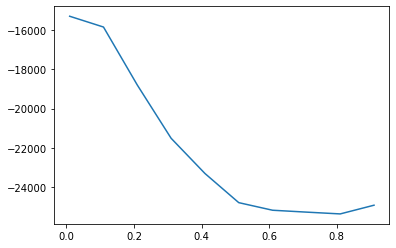

In [20]:
plt.plot([0.01+0.1*i for i in range(0,10)],mle_tests)

### Q:
SGD for subsets of spatial grid?

### TODO
 - Replace cdf by MC estimate in nll
 - parallelise after that using ritos package